## StackingRegressor

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection   import RandomizedSearchCV
import joblib

In [2]:
# Load data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
# Split features/target
X_train = train.drop('Score', axis=1)
y_train = train['Score']
X_test  = test.drop('Score', axis=1)
y_test  = test['Score']

In [4]:
preprocessor = joblib.load("preprocessor_unfitted.joblib")

## Pipeline and RandomizedSearchCV

In [5]:
# Stacking pipeline
estimators = [
    ('rf', RandomForestRegressor(random_state=42, n_estimators=200, max_depth=9)),
    ('et', ExtraTreesRegressor(random_state=42, n_estimators=100, max_depth=18)),
    ('gb', GradientBoostingRegressor(random_state=42, n_estimators=100, max_depth=3))
]
stack_pipe = Pipeline([
    ("prep", preprocessor),
    ("model", StackingRegressor(
        estimators=estimators,
        final_estimator=Ridge(random_state=42),
        passthrough=False,
        n_jobs=-1
    ))
])

In [6]:
#  Hyper‐parameter distributions
param_dist = {
    "model__passthrough": [True, False],
    "model__final_estimator__alpha": [0.05, 0.1, 1.0,]
}

# 5) RandomizedSearchCV
stack_search = RandomizedSearchCV(
    estimator           = stack_pipe,
    param_distributions = param_dist,
    n_iter              = 6,
    cv                  = 3,
    scoring             = "neg_mean_squared_error",
    n_jobs              = -1,
    random_state        = 42,
    verbose             = 2
)

In [7]:
#  Fit & evaluate
print("Searching StackingRegressor…")
stack_search.fit(X_train, y_train)

Searching StackingRegressor…
Fitting 3 folds for each of 6 candidates, totalling 18 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['WhiteElo',
                                                                                'EloDif']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['Opening_name',
 

In [8]:
print(f"Best params:", stack_search.best_params_)
print(f"AdaBoostRegressor best CV MSE: {-stack_search.best_score_:.4f}")
best_stack_reg = stack_search.best_estimator_

Best params: {'model__passthrough': False, 'model__final_estimator__alpha': 0.05}
AdaBoostRegressor best CV MSE: 0.2248


In [9]:
# Final eval on test set
y_pred = best_stack_reg.predict(X_test)
print(f"Test MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"Test R²:  {r2_score(y_test, y_pred):.4f}")

Test MSE: 0.2261
Test MAE: 0.4561
Test R²:  0.0400


[learning_curve] Training set sizes: [  466  1651  2835  4020  5205  6389  7574  8758  9943 11128 12312 13497
 14681 15866 17051 18235 19420 20604 21789 22974 24158 25343 26527 27712
 28897 30081 31266 32450 33635 34820 36004 37189 38373 39558 40743 41927
 43112 44296 45481 46666]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of 120 | elapsed: 33.7min remaining: 33.7min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 78.6min finished


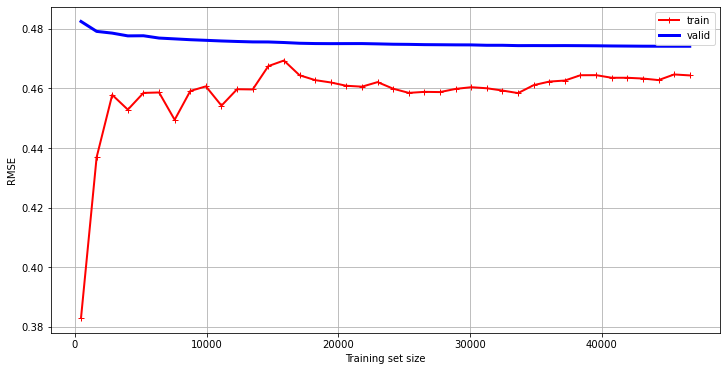

In [10]:
# Plot the learning curve for the StackingRegressor
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(best_stack_reg,
                                                         X_train, y_train,
                                                         train_sizes = np.linspace(0.01, 1.0, 40),
                                                         cv = 3,
                                                         scoring = "neg_root_mean_squared_error", 
                                                         n_jobs      = -1,
                                                         verbose     = 2 )

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

fig = plt.figure(figsize = (12, 6))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
plt.show()

In [11]:
joblib.dump(best_stack_reg, "best_stack_reg.joblib")

['best_stack_reg.joblib']